<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0529transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 2020年度 駒澤大学文学部心理学特講IIIA 
<div align="right">
<img src="https://koma-sso.komazawa-u.ac.jp/idp/images/header_logo.png">
</div>

# 転移学習のデモ

- source: https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/transfer_learning_tutorial.ipynb
- date: 2020-0529
- note: for 駒澤大学授業用
- original author: Sasank Chilamkurthy <https://chsasank.github.io>
- [授業ページ](https://komazawa-deep-learning.github.io/)

In [ ]:
%matplotlib inline


In this tutorial, you will learn how to train your network using transfer learning. 
You can read more about the transfer learning at `cs231n notes <http://cs231n.github.io/transfer-learning/>`

Quoting these notes,

    実際には、十分なサイズのデータセットを持っている人は比較的少ないので、
    ゼロから（ランダムな初期化をして）コンボリューションネットワーク全体を
    トレーニングする人はほとんどいません。その代わりに，非常に大規模なデータ
    セット（例えば，1000のカテゴリを持つ120万枚の画像を含むImageNetなど）
    で 畳み込みニューラルネットワークを事前に訓練しておき，その 畳み込み
    ニューラルネットワーク を初期化または目的の課題の固定的特徴抽出器として
    使用するのが一般的です．

These two major transfer learning scenarios look as follows:

この2つの主要な転送学習シナリオは以下のようになります。

- **畳込みニューラルネットワークのファインチューニング** ランダムな初期化の代わりに、imagenet 1000データセットで訓練されたもののように、事前に訓練されたネットワークでネットワークを初期化します。
残りの学習は通常通りに行います。

- **固定的特徴抽出器としての畳み込みニューラルネットワーク** ここでは、最後の完全に接続された層以外のネットワークの重みを凍結します。
この最後の完全に接続された層は、ランダムな重みを持つ新しい層に置き換えられ、この層だけが学習される。


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# データの読み込み

データの読み込みには `torchvision` と `torch.utils.data` パッケージを使用します。

今日解く問題は、**アリ** と **ハチ** を分類するモデルを訓練することです。
アリとハチについて、それぞれ約 120 枚の訓練画像があります。
各クラスには75枚の検証画像があります。
通常、ゼロから学習した場合、これは一般化するには非常に小さなデータセットです。
我々は伝達学習を使用しているので、合理的に一般化することができるはずです。

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip 
!unzip hymenoptera_data.zip > /dev/null

In [ ]:
# データ拡張 を行います Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 画像の表示

Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# モデルの訓練

<!--Now, let's write a general function to train a model. Here, we will
illustrate:-->

ここでは, 以下のことを行います
-  学習係数のスケジューリング  <!--Scheduling the learning rate-->
-  モデルの保存 <!--Saving the best model-->

以下では，パラメータ `scheduler` が 学習係数 LR のスケジューラです.

<!--In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.-->



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## モデル予測の表示 
<!--Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^-->

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ファインチューニング

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 訓練と評価 
<!-- Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.
-->

GPU を使っても 30 分くらいかかります。なので以下のセルは実行しないでください。



In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

# 転移学習

転移学習は 最終層以外のネットワークをすべて固定化 (フリーズ) させる必要があります。
`requires_grad == False` を設定してパラメータをフリーズさせ、 `backward()` 
で勾配計算がされないようにします。

細かい点はマニュアルを参照してください
<!--You can read more about this in the documentation-->
<http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 訓練と評価
<!-- Train and evaluate
^^^^^^^^^^^^^^^^^^
-->

<!--
On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.
-->

ほとんどの結合係数の勾配計算をしないため CPU でもすぐに終わります


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

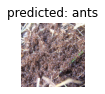

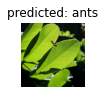

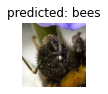

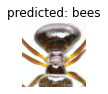

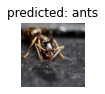

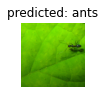

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()